**Aribnb房价预测


In [1]:
#导入相关包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#导入数据
train = pd.read_csv('train_users_2.csv')
test = pd.read_csv('test_users.csv')

In [7]:
#查看数据集中的特征信息
print('train sets size', train.shape)
print('\n')
print('feature names in training set')
train.columns

train sets size (213451, 16)


feature names in training set


Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [8]:
print('test sets size', test.shape)
print('\n')
print('feature names in test set')
test.columns

test sets size (62096, 15)


feature names in test set


Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object')

这里会发现训练数据集和测试数据集的特征数量不等！从下面会发现，test set中没有{'country_destination'}，因为这就是我们需要预测的label！

In [9]:
set(train.columns) - set(test.columns)

{'country_destination'}

In [10]:
#查看数据详细信息
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


tips：
1.注意其中的样本数量213451，特征数量16（其中id对模型并无多大作用-index，对特征工程有用；而最后一个特征country_destination实为label）
2.需要注意一些数据的类型：object，float，int
3. 完全可以考虑删除缺失值较多的特征，没有问题

In [11]:
#查看数据
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [10]:
#对date_account_created数据进行统计
# train set
train.date_account_created.value_counts().head()

2014-05-13    674
2014-06-24    670
2014-06-25    636
2014-05-20    632
2014-05-14    622
Name: date_account_created, dtype: int64

In [11]:
#test set
test.date_account_created.value_counts().head()

2014-07-23    1105
2014-07-22    1052
2014-07-17     978
2014-07-24     923
2014-07-18     892
Name: date_account_created, dtype: int64

tips：
这里之所以要查看‘创建账号’的时间信息，是为了分析其用户数量增长情况。
但是对于最总预测有没有用，暂时没发现！
对于预测目的来说应该是没用的，存疑？

In [12]:
train.date_account_created.describe()

count         213451
unique          1634
top       2014-05-13
freq             674
Name: date_account_created, dtype: object

describe()函数可以用来描述数据的统计信息，包括max，min，mean等

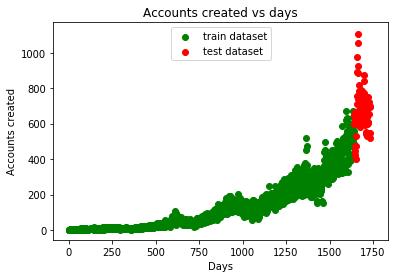

In [21]:
#观察用户增长情况
dac_train = train.date_account_created.value_counts()
dac_test = test.date_account_created.value_counts()

dac_train_date = pd.to_datetime(train.date_account_created.value_counts().index)
dac_test_date = pd.to_datetime(test.date_account_created.value_counts().index)    #这里index

dac_train_day = dac_train_date - dac_train_date.min()
dac_test_day = dac_test_date - dac_train_date.min()      #这里要都减去train data的起始时间

plt.scatter(dac_train_day.days, dac_train.values, color = 'g', label = 'train dataset')
plt.scatter(dac_test_day.days, dac_test.values, color = 'r', label = 'test dataset')

plt.title('Accounts created vs days')
plt.xlabel('Days')
plt.ylabel('Accounts created')
plt.legend(loc = 'upper center')

tips：
1 这里注意一下，原数据中‘date_account_created’是object类型的，不能直接减运算，所以需要用pd.to_datetime转换成datetime类型；
2 之所以要.index再转换，可以看一下dac_train中其index为日期，值为这个日期的数量
3 **可以看到随着时间增长用户注册数量在上升，很自然的事情

In [22]:
# timestamp_first_active（首次活跃时间）
# 查看头几行数据
train.timestamp_first_active.head()

0    20090319043255
1    20090523174809
2    20090609231247
3    20091031060129
4    20091208061105
Name: timestamp_first_active, dtype: int64

这里需要注意数据类型！

In [23]:
train.timestamp_first_active.value_counts().unique()

array([1], dtype=int64)

结果[1]表明timestamp_first_active没有重复数据

In [26]:
tfa_train_dt = train.timestamp_first_active.astype(str).apply(lambda x: pd.datetime(int(x[0:4]),int(x[4:6]), int(x[6:8]), int(x[8:10]), int(x[10:12]), int(x[12:])))
tfa_train_dt.describe()

count                  213451
unique                 213451
top       2013-07-01 05:26:34
freq                        1
first     2009-03-19 04:32:55
last      2014-06-30 23:58:24
Name: timestamp_first_active, dtype: object

tips:
这里要注意一下pd.datetime的应用。

In [27]:
#获取date_first_booking信息
print(train.date_first_booking.describe())
print(test.date_first_booking.describe())

count          88908
unique          1976
top       2014-05-22
freq             248
Name: date_first_booking, dtype: object
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: date_first_booking, dtype: float64


tips：
可以看到train set中date_first_booking缺失值超过一半了，而在tes他set中没有date_first_booking数据。所以可以将这个feature直接删掉。

In [12]:
train.drop(['date_first_booking'], axis = 1, inplace = True)
test.drop(['date_first_booking'], axis = 1, inplace = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 15 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(12)
memory usage: 24.4+ MB


In [13]:
#对‘age’数据进行统计
train.age.value_counts().head()

30.0    6124
31.0    6016
29.0    5963
28.0    5939
32.0    5855
Name: age, dtype: int64

In [15]:
train.age.value_counts().tail()

1933.0    1
1942.0    1
112.0     1
1938.0    1
1952.0    1
Name: age, dtype: int64

这些1千多的肯定就是异常值了！需要对异常值进行处理！

In [16]:
#柱状图统计
#先导入seaborn

import seaborn as sns

#首先将年龄进行分成4组missing values, too small age, reasonable age, too large age
age_train = [train[train.age.isnull()].age.shape[0], train.query('age < 15').age.shape[0], train.query('age >= 15 & age <= 90').age.shape[0], train.query('age > 90').age.shape[0]]
age_test = [train[train.age.isnull()].age.shape[0], train.query('age < 15').age.shape[0], train.query('age >= 15 & age <= 90').age.shape[0], train.query('age > 90').age.shape[0]]

columns = ['Null', 'age < 15', 'age', 'age> 90']
fig, (ax1, ax2) = plt.subplots(1,2,sharex = True, sharey = True, figsize = (10,5))

sns.barplot(columns, age_train, ax = ax1)
sns.barplot(columns,age_test, ax = ax2)

ax1.set_title('training dataset')
ax2.set_title('test dataset')
ax1.set_ylabel('conts')

In [17]:
def feature_barplot(feature, df_train = train, df_test = test, figsize=(10,5), rot = 90, saveimg = False): 
    feat_train = df_train[feature].value_counts() 
    feat_test = df_test[feature].value_counts() 
    fig_feature, (axis1,axis2) = plt.subplots(1,2,sharex=True, sharey = True, figsize = figsize) 
    sns.barplot(feat_train.index.values, feat_train.values, ax = axis1) 
    sns.barplot(feat_test.index.values, feat_test.values, ax = axis2) 
    axis1.set_xticklabels(axis1.xaxis.get_majorticklabels(), rotation = rot) 
    axis2.set_xticklabels(axis1.xaxis.get_majorticklabels(), rotation = rot) 
    axis1.set_title(feature + ' of training dataset') 
    axis2.set_title(feature + ' of test dataset') 
    axis1.set_ylabel('Counts') 
    plt.tight_layout() 
    if saveimg == True: 
        figname = feature + ".png" 
        fig_feature.savefig(figname, dpi = 75)


In [18]:
feature_barplot('gender', saveimg = False)

In [19]:
feature_barplot('signup_method')

In [20]:
feature_barplot('language')

In [21]:
feature_barplot('affiliate_channel')

In [22]:
feature_barplot('first_affiliate_tracked')

In [24]:
feature_barplot('signup_app')

In [ ]:
feature_barplot('first_device_type')

In [25]:
df_sessions = pd.read_csv('sessions.csv')


NameError: name 'df' is not defined

In [27]:
df_sessions.head(3)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0


In [28]:
df_sessions.rename(columns = {'user_id' : 'id'}, inplace = True)
df_sessions.head(1)

,id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0


将seession中的‘user_id'换成’id'方便后面进行文件合并。

In [29]:
df_sessions.shape

(10567737, 6)

In [37]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
id               object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [36]:
df_sessions.isnull().sum()  #查看缺失值

id                 34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [38]:
#填充缺失值,填充空值
df_sessions.action = df_sessions.action.fillna('NAN') 
df_sessions.action_type = df_sessions.action_type.fillna('NAN') 
df_sessions.action_detail = df_sessions.action_detail.fillna('NAN') 
df_sessions.isnull().sum()

id                34496
action                0
action_type           0
action_detail         0
device_type           0
secs_elapsed     136031
dtype: int64

最后一个属性‘secs_elapsed’表示停留属性，这个应该是很有用的，并且是数值型的数据。

# 特征提取

In [39]:
df_sessions.action.head()

0            lookup
1    search_results
2            lookup
3    search_results
4            lookup
Name: action, dtype: object

In [ ]:
我们可以通过value_counts()来看个action的数量，发现其中会有大量的action数量很少，1、2等
可以考虑将这些操作归为一类。

In [42]:
df_sessions.action.value_counts().min()

1

In [43]:
#Action values with low frequency are changed to 'OTHER' 
act_freq = 100 #Threshold of frequency ，选择的阈值，将小于这个阈值的action都设置为others
act = dict(zip(*np.unique(df_sessions.action, return_counts=True))) 
df_sessions.action = df_sessions.action.apply(lambda x: 'OTHER' if act[x] < act_freq else x) 
#np.unique(df_sessions.action, return_counts=True) 取以数组形式返回非重复的action值和它的数量 
#zip（*（a,b））a,b种元素一一对应，返回zip object


2. 对特征action，action_detail，action_type，device_type，secs_elapsed进行细化
- 首先将用户的特征根据用户id进行分组
- 特征action：统计每个用户总的action出现的次数，各个action类型的数量，平均值以及标准差
- 特征action_detail：统计每个用户总的action_detail出现的次数，各个action_detail类型的数量，平均值以及标准差
- 特征action_type：统计每个用户总的action_type出现的次数，各个action_type类型的数量，平均值，标准差以及总的停留时长（进行log处理）
- 特征device_type：统计每个用户总的device_type出现的次数，各个device_type类型的数量，平均值以及标准差
- 特征secs_elapsed：对缺失值用0填充，统计每个用户secs_elapsed时间的总和，平均值，标准差以及中位数（进行log处理），（总和/平均数），secs_elapsed（log处理后）各个时间出现的次数


In [44]:
f_act = df_sessions.action.value_counts().argsort()
f_act.head(3)

show              230
index             229
search_results    227
Name: action, dtype: int64

In [46]:
#对action特征进行细化 
f_act = df_sessions.action.value_counts().argsort() 
f_act_detail = df_sessions.action_detail.value_counts().argsort() 
f_act_type = df_sessions.action_type.value_counts().argsort() 
f_dev_type = df_sessions.device_type.value_counts().argsort() 

#按照id进行分组 
dgr_sess = df_sessions.groupby(['id']) 
#Loop on dgr_sess to create all the features.
samples = [] #samples列表
ln = len(dgr_sess) #计算分组后df_sessions的长度

for g in dgr_sess:  #对dgr_sess中每个id的数据进行遍历
    gr = g[1]   #data frame that comtains all the data for a groupby value 'zzywmcn0jv'

    l = []  #建一个空列表，临时存放特征

    #the id    for example:'zzywmcn0jv'
    l.append(g[0]) #将id值放入空列表中

    # number of total actions
    l.append(len(gr))#将id对应数据的长度放入列表

    #secs_elapsed 特征中的缺失值用0填充再获取具体的停留时长值
    sev = gr.secs_elapsed.fillna(0).values   #These values are used later.

    #action features 特征-用户行为 
    #每个用户行为出现的次数，各个行为类型的数量，平均值以及标准差
    c_act = [0] * len(f_act)
    for i,v in enumerate(gr.action.values): #i是从0-1对应的位置，v 是用户行为特征的值
        c_act[f_act[v]] += 1
    _, c_act_uqc = np.unique(gr.action.values, return_counts=True)
    #计算用户行为行为特征各个类型数量的长度，平均值以及标准差
    c_act += [len(c_act_uqc), np.mean(c_act_uqc), np.std(c_act_uqc)]
    l = l + c_act

    #action_detail features 特征-用户行为具体
    #(how many times each value occurs, numb of unique values, mean and std)
    c_act_detail = [0] * len(f_act_detail)
    for i,v in enumerate(gr.action_detail.values):
        c_act_detail[f_act_detail[v]] += 1
    _, c_act_det_uqc = np.unique(gr.action_detail.values, return_counts=True)
    c_act_detail += [len(c_act_det_uqc), np.mean(c_act_det_uqc), np.std(c_act_det_uqc)]
    l = l + c_act_detail

    #action_type features  特征-用户行为类型 click等
    #(how many times each value occurs, numb of unique values, mean and std
    #+ log of the sum of secs_elapsed for each value)
    l_act_type = [0] * len(f_act_type)
    c_act_type = [0] * len(f_act_type)
    for i,v in enumerate(gr.action_type.values):
        l_act_type[f_act_type[v]] += sev[i] #sev = gr.secs_elapsed.fillna(0).values ，求每个行为类型总的停留时长
        c_act_type[f_act_type[v]] += 1  
    l_act_type = np.log(1 + np.array(l_act_type)).tolist() #每个行为类型总的停留时长，差异比较大，进行log处理
    _, c_act_type_uqc = np.unique(gr.action_type.values, return_counts=True)
    c_act_type += [len(c_act_type_uqc), np.mean(c_act_type_uqc), np.std(c_act_type_uqc)]
    l = l + c_act_type + l_act_type    

    #device_type features 特征-设备类型
    #(how many times each value occurs, numb of unique values, mean and std)
    c_dev_type  = [0] * len(f_dev_type)
    for i,v in enumerate(gr.device_type .values):
        c_dev_type[f_dev_type[v]] += 1 
    c_dev_type.append(len(np.unique(gr.device_type.values))) 
    _, c_dev_type_uqc = np.unique(gr.device_type.values, return_counts=True)
    c_dev_type += [len(c_dev_type_uqc), np.mean(c_dev_type_uqc), np.std(c_dev_type_uqc)]        
    l = l + c_dev_type    

    #secs_elapsed features  特征-停留时长     
    l_secs = [0] * 5 
    l_log = [0] * 15
    if len(sev) > 0:
        #Simple statistics about the secs_elapsed values.
        l_secs[0] = np.log(1 + np.sum(sev))
        l_secs[1] = np.log(1 + np.mean(sev)) 
        l_secs[2] = np.log(1 + np.std(sev))
        l_secs[3] = np.log(1 + np.median(sev))
        l_secs[4] = l_secs[0] / float(l[1]) #

        #Values are grouped in 15 intervals. Compute the number of values
        #in each interval.
        #sev = gr.secs_elapsed.fillna(0).values 
        log_sev = np.log(1 + sev).astype(int)
        #np.bincount():Count number of occurrences of each value in array of non-negative ints.  
        l_log = np.bincount(log_sev, minlength=15).tolist()                    
    l = l + l_secs + l_log

    #The list l has the feature values of one sample.
    samples.append(l)

#preparing objects    
samples = np.array(samples) 
samp_ar = samples[:, 1:].astype(np.float16) #取除id外的特征数据
samp_id = samples[:, 0]   #取id，id位于第一列

#为提取的特征创建一个dataframe     
col_names = []    #name of the columns
for i in range(len(samples[0])-1):  #减1的原因是因为有个id
    col_names.append('c_' + str(i))  #起名字的方式    
df_agg_sess = pd.DataFrame(samp_ar, columns=col_names)
df_agg_sess['id'] = samp_id
df_agg_sess.index = df_agg_sess.id #将id作为index


In [47]:
df_agg_sess.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456,id
id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,6.0,2.0,3.0,3.0,1.0,0.0,1.0,0.0,00023iyk9l
0010k6l0om,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,12.0,2.0,8.0,4.0,3.0,0.0,0.0,0.0,0010k6l0om
001wyh0pz8,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,30.0,9.0,8.0,1.0,0.0,0.0,0.0,0.0,001wyh0pz8
0028jgx1x1,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,5.0,4.0,1.0,0.0,0.0,0.0,0028jgx1x1
002qnbzfs5,789.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,111.0,102.0,104.0,57.0,28.0,9.0,4.0,1.0,1.0,002qnbzfs5


In [48]:
train_row = train.shape[0]
labels = train['country_destination'].values

In [49]:
#合并train和test文件
df = pd.concat([train, test], axis = 0, ignore_index = True)

In [52]:
#转换为datetime类型
import datetime
tfa = df.timestamp_first_active.astype(str).apply(lambda x: datetime.datetime(int(x[:4]), 
                                                                              int(x[4:6]), 
                                                                              int(x[6:8]), 
                                                                              int(x[8:10]), 
                                                                              int(x[10:12]), 
                                                                              int(x[12:])))


In [57]:
tfa.head(2)

0   2009-03-19 04:32:55
1   2009-05-23 17:48:09
Name: timestamp_first_active, dtype: datetime64[ns]

In [53]:
#提取年月日特征
# create tfa_year, tfa_month, tfa_day feature
df['tfa_year'] = np.array([x.year for x in tfa])
df['tfa_month'] = np.array([x.month for x in tfa])
df['tfa_day'] = np.array([x.day for x in tfa])


In [54]:
# 提取特征：weekday
#isoweekday() 可以返回一周的星期几，e.g.星期日：0；星期一：1 
df['tfa_wd'] = np.array([x.isoweekday() for x in tfa]) 
df_tfa_wd = pd.get_dummies(df.tfa_wd, prefix = 'tfa_wd') # one hot encoding 
df = pd.concat((df, df_tfa_wd), axis = 1) #添加df['tfa_wd'] 编码后的特征 
df.drop(['tfa_wd'], axis = 1, inplace = True)#删除原有未编码的特征


In [65]:
#提取特征：季节
Y = 2000 
seasons = [(0, (datetime.date(Y,1,1), datetime.date(Y,3,20))), #'winter' 
           (1, (datetime.date(Y,3,21), datetime.date(Y,6,20))), #'spring' 
           (2, (datetime.date(Y,6,21), datetime.date(Y,9,20))), #'summer' 
           (3, (datetime.date(Y,9,21), datetime.date(Y,12,20))), #'autumn' 
           (0, (datetime.date(Y,12,21), datetime.date(Y,12,31)))] #'winter' 
def get_season(dt): 
    dt = dt.date() #获取日期 
    dt = dt.replace(year=Y) #将年统一换成2000年 
    return next(season for season, (start, end) in seasons if start <= dt <= end) 
df['tfa_season'] = np.array([get_season(x) for x in tfa]) 
df_tfa_season = pd.get_dummies(df.tfa_season, prefix = 'tfa_season') # one hot encoding 
df = pd.concat((df, df_tfa_season), axis = 1) 
df.drop(['tfa_season'], axis = 1, inplace = True)


In [66]:
#将date_account_created转换为datetime类型
dac = pd.to_datetime(df.date_account_created)

In [67]:
#提取特征：年，月，日
df['dac_year'] = np.array([x.year for x in dac]) 
df['dac_month'] = np.array([x.month for x in dac]) 
df['dac_day'] = np.array([x.day for x in dac])


In [68]:
#提取weekday特征
df['dac_wd'] = np.array([x.isoweekday() for x in dac])
df_dac_wd = pd.get_dummies(df.dac_wd, prefix = 'dac_wd') 
df = pd.concat((df, df_dac_wd), axis = 1) 
df.drop(['dac_wd'], axis = 1, inplace = True)

In [69]:
#提取季节特征
df['dac_season'] = np.array([get_season(x) for x in dac]) 
df_dac_season = pd.get_dummies(df.dac_season, prefix = 'dac_season') 
df = pd.concat((df, df_dac_season), axis = 1) 
df.drop(['dac_season'], axis = 1, inplace = True)


In [70]:
#提取特征：date_account_created和timestamp_first_active之间的差值
dt_span = dac.subtract(tfa).dt.days 
dt_span.value_counts().head(10)

-1     275369
 0          7
 6          4
 5          4
 1          4
 2          3
 3          3
 4          3
 28         3
 94         2
dtype: int64

In [71]:
#create categorical feature: span = -1; -1 < span < 30; 31 < span < 365; span > 365 
def get_span(dt): 
    # dt is an integer 
    if dt == -1: 
        return 'OneDay' 
    elif (dt < 30) & (dt > -1): 
        return 'OneMonth' 
    elif (dt >= 30) & (dt <= 365): 
        return 'OneYear' 
    else: 
        return 'other' 
df['dt_span'] = np.array([get_span(x) for x in dt_span]) 
df_dt_span = pd.get_dummies(df.dt_span, prefix = 'dt_span') 
df = pd.concat((df, df_dt_span), axis = 1) 
df.drop(['dt_span'], axis = 1, inplace = True)


In [72]:
#删除原有特征
df.drop(['date_account_created','timestamp_first_active'], axis = 1, inplace = True)

在数据探索阶段，我们发现大部分数据是集中在（15，90）区间的，但有部分年龄分布在（1900，2000）区间，我们猜测用户是把出生日期误填为年龄，故进行预处理

In [73]:
av = df.age.values
#This are birthdays instead of age (estimating age by doing 2014 - value)
#数据来自2014年，故用2014-value 
av = np.where(np.logical_and(av<2000, av>1900), 2014-av, av) 
df['age'] = av


C:\Users\mail\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
C:\Users\mail\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [75]:
#将年龄进行分段
age = df.age 
age.fillna(-1, inplace = True) #空值填充为-1 
div = 15 
def get_age(age): 
    # age is a float number  将连续型转换为离散型 
    if age < 0: 
        return 'NA' #表示是空值 
    elif (age < div): 
        return div #如果年龄小于15岁，那么返回15岁 
    elif (age <= div * 2): 
        return div*2 #如果年龄大于15小于等于30岁，则返回30岁 
    elif (age <= div * 3): 
        return div * 3 
    elif (age <= div * 4): 
        return div * 4 
    elif (age <= div * 5): 
        return div * 5 
    elif (age <= 110): 
        return div * 6 
    else: return 'Unphysical' #非正常年龄


In [76]:
#创建新的‘age'特征
df['age'] = np.array([get_age(x) for x in age]) 
df_age = pd.get_dummies(df.age, prefix = 'age') 
df = pd.concat((df, df_age), axis = 1) 
df.drop(['age'], axis = 1, inplace = True)

In [77]:
#其他特征，直接onehot编码
feat_toOHE = ['gender', 
              'signup_method', 
              'signup_flow', 
              'language', 
              'affiliate_channel', 
              'affiliate_provider', 
              'first_affiliate_tracked', 
              'signup_app', 
              'first_device_type', 
              'first_browser'] 
#对其他特征进行one-hot-encoding处理 
for f in feat_toOHE: 
    df_ohe = pd.get_dummies(df[f], prefix=f, dummy_na=True) 
    df.drop([f], axis = 1, inplace = True) 
    df = pd.concat((df, df_ohe), axis = 1)


In [78]:
#将上面session和train及test得到的特征进行合并
#将对session提取的特征整合到一起 
df_all = pd.merge(df, df_agg_sess, how='left') 
df_all = df_all.drop(['id'], axis=1) #删除id 
df_all = df_all.fillna(-2) #对没有sesssion data的特征进行缺失值处理 
#加了一列，表示每一行总共有多少空值，这也作为一个特征 
#df_all['all_null'] = np.array([sum(r<0) for r in df_all.values]) 

TypeError: '<' not supported between instances of 'str' and 'int'

In [79]:
df_all.head(2)

,country_destination,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,...,c_447,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456
0,NDF,2009,3,19,0,0,0,1,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,NDF,2009,5,23,0,0,0,0,0,1,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


#模型构建：
主要选择了逻辑回归模型，树模型，SVM，以及xgboost模型

In [ ]:
#选出训练集和测试集并保存
Xtrain = df_all.iloc[:train_row, :]
Xtest = df_all.iloc[train_row:, :]
Xtrain.to_csv("Airbnb_xtrain_v2.csv")
Xtest.to_csv("Airbnb_xtest_v2.csv")
#labels.tofile（）：Write array to a file as text or binary (default)
labels.tofile("Airbnb_ytrain_v2.csv", sep='\n', format='%s') #存放目标变量

In [ ]:
xtrain = Xtrain
ytrain = labels

In [ ]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelBinarizer

In [ ]:
#对目标变量进行encoding
le = LabelEncoder()
ytrain_le = le.fit_transform(ytrain.values)

In [ ]:
#提取10%的数据进行训练
# Let us take 10% of the data for faster training. 
n = int(xtrain.shape[0]*0.1) 
xtrain_new = xtrain.iloc[:n, :] #训练数据 
ytrain_new = ytrain_le[:n] #训练数据的目标变量

In [ ]:
#将所有的数据都规范化0-1
X_scaler = StandardScaler()
xtrain_new = X_scaler.fit_transform(xtrain_new)

评分模型：NDCG
NDCG是一种衡量排序质量的评价指标，该指标考虑了所有元素的相关性
由于我们预测的目标变量并不是二分类变量，故我们用NDGG模型来进行模型评分，判断模型优劣
一般二分类变量: 我们习惯于使用 f1 score, precision, recall, auc score来进行模型评分

In [ ]:
from sklearn.metrics import make_scorer 
def dcg_score(y_true, y_score, k=5): 
    """
    y_true : array, shape = [n_samples] #数据
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes] #预测的分数
        Predicted scores.
    k : int
    """ 
    order = np.argsort(y_score)[::-1] #分数从高到低排序 
    y_true = np.take(y_true, order[:k]) #取出前k[0,k）个分数 
    gain = 2 ** y_true - 1 
    discounts = np.log2(np.arange(len(y_true)) + 2) 
    return np.sum(gain / discounts) 

def ndcg_score(ground_truth, predictions, k=5): 
    """
    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes] 
        Predicted probabilities. 预测的概率
    k : int
        Rank.
    """ 
    lb = LabelBinarizer() 
    lb.fit(range(len(predictions) + 1)) 
    T = lb.transform(ground_truth) 
    scores = [] 
    # Iterate over each y_true and compute the DCG score 
    for y_true, y_score in zip(T, predictions): 
        actual = dcg_score(y_true, y_score, k) 
        best = dcg_score(y_true, y_true, k) 
        score = float(actual) / float(best) 
        scores.append(score) 
        return np.mean(scores)

#模型构建

In [ ]:
#逻辑回归
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split 
lr = LogisticRegression(C = 1.0, penalty='l2', multi_class='ovr') 
RANDOM_STATE = 2017 #随机种子 #k-fold cross validation（k-折叠交叉验证） 
kf = KFold(n_splits=5, random_state=RANDOM_STATE) #分成5个组 
train_score = [] 
cv_score = [] 
# select a k  (value how many y): 
k_ndcg = 3 
# kf.split: Generate indices to split data into training and test set. 
for train_index, test_index in kf.split(xtrain_new, ytrain_new): 
    #训练集数据分割为训练集和测试集，y是目标变量 
    X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :] 
    y_train, y_test = ytrain_new[train_index], ytrain_new[test_index] 
    lr.fit(X_train, y_train) 
    y_pred = lr.predict_proba(X_test) 
    train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k = k_ndcg) 
    cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg) 
    train_score.append(train_ndcg_score) 
    cv_score.append(cv_ndcg_score) 
    print ("\nThe training score is: {}".format(np.mean(train_score))) 
    print ("\nThe cv score is: {}".format(np.mean(cv_score)))


In [ ]:
#改变迭代次数
# set the iterations 
iteration = [1,5,10,15,20, 50, 100] 
kf = KFold(n_splits=3, random_state=RANDOM_STATE) 
train_score = [] 
cv_score = [] 
# select a k: 
k_ndcg = 5 
for i, item in enumerate(iteration): 
    lr = LogisticRegression(C=1.0, max_iter=item, tol=1e-5, solver='newton-cg', multi_class='ovr') 
    train_score_iter = [] 
    cv_score_iter = [] 
    for train_index, test_index in kf.split(xtrain_new, ytrain_new): 
        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :] 
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index] 
        lr.fit(X_train, y_train) y_pred = lr.predict_proba(X_test) 
        train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k = k_ndcg) 
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg) 
        train_score_iter.append(train_ndcg_score) 
        cv_score_iter.append(cv_ndcg_score) 
    train_score.append(np.mean(train_score_iter)) 
    cv_score.append(np.mean(cv_score_iter))


In [ ]:
ymin = np.min(cv_score)-0.05 
ymax = np.max(train_score)+0.05 
plt.figure(figsize=(9,4)) 
plt.plot(iteration, train_score, 'ro-', label = 'training') 
plt.plot(iteration, cv_score, 'b*-', label = 'Cross-validation') 
plt.xlabel("iterations") 
plt.ylabel("Score") 
plt.xlim(-5, np.max(iteration)+10) 
plt.ylim(ymin, ymax) 
plt.plot(np.linspace(20,20,50), np.linspace(ymin, ymax, 50), 'g--') 
plt.legend(loc = 'lower right', fontsize = 12) 
plt.title("Score vs iteration learning curve") 
plt.tight_layout()

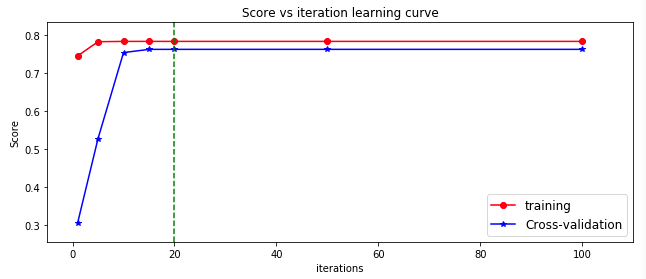

In [ ]:
#改变数据量大小
# Chaning the sampling size # set the iter to the best iteration: iter = 20 
perc = [0.01,0.02,0.05,0.1,0.2,0.5,1] 
kf = KFold(n_splits=3, random_state=RANDOM_STATE) 
train_score = [] 
cv_score = [] # select a k: 
k_ndcg = 5 
for i, item in enumerate(perc): 
    lr = LogisticRegression(C=1.0, max_iter=20, tol=1e-6, solver='newton-cg', multi_class='ovr') 
    train_score_iter = [] 
    cv_score_iter = [] 
    n = int(xtrain_new.shape[0]*item) 
    xtrain_perc = xtrain_new[:n, :] 
    ytrain_perc = ytrain_new[:n] 
    for train_index, test_index in kf.split(xtrain_perc, ytrain_perc): 
        X_train, X_test = xtrain_perc[train_index, :], xtrain_perc[test_index, :] 
        y_train, y_test = ytrain_perc[train_index], ytrain_perc[test_index] 
        print(X_train.shape, X_test.shape) 
        lr.fit(X_train, y_train) 
        y_pred = lr.predict_proba(X_test) 
        train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k = k_ndcg) 
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg) 
        train_score_iter.append(train_ndcg_score) 
        cv_score_iter.append(cv_ndcg_score) 
    train_score.append(np.mean(train_score_iter)) 
    cv_score.append(np.mean(cv_score_iter))


In [ ]:
ymin = np.min(cv_score)-0.1 
ymax = np.max(train_score)+0.1 
plt.figure(figsize=(9,4)) 
plt.plot(np.array(perc)*100, train_score, 'ro-', label = 'training') 
plt.plot(np.array(perc)*100, cv_score, 'bo-', label = 'Cross-validation') 
plt.xlabel("Sample size (unit %)") 
plt.ylabel("Score") 
plt.xlim(-5, np.max(perc)*100+10) 
plt.ylim(ymin, ymax) 
plt.legend(loc = 'lower right', fontsize = 12) 
plt.title("Score vs sample size learning curve") 
plt.tight_layout()


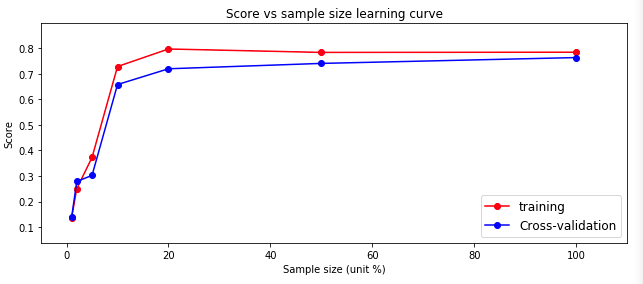

In [ ]:
#树模型
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import * 
from sklearn.svm import SVC, LinearSVC, NuSVC 
LEARNING_RATE = 0.1 
N_ESTIMATORS = 50 
RANDOM_STATE = 2017 
MAX_DEPTH = 9 
#建了一个tree字典 
clf_tree ={ 
    'DTree': DecisionTreeClassifier(max_depth=MAX_DEPTH, 
                                    random_state=RANDOM_STATE), 
    'RF': RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, 
                                 random_state=RANDOM_STATE), 
    'AdaBoost': AdaBoostClassifier(n_estimators=N_ESTIMATORS, 
                                   learning_rate=LEARNING_RATE, 
                                   random_state=RANDOM_STATE), 
    'Bagging': BaggingClassifier(n_estimators=N_ESTIMATORS, 
                                 random_state=RANDOM_STATE), 
    'ExtraTree': ExtraTreesClassifier(max_depth=MAX_DEPTH, 
                                      n_estimators=N_ESTIMATORS, 
                                      random_state=RANDOM_STATE), 
    'GraBoost': GradientBoostingClassifier(learning_rate=LEARNING_RATE,
                                           max_depth=MAX_DEPTH, 
                                           n_estimators=N_ESTIMATORS, 
                                           random_state=RANDOM_STATE) } 
train_score = [] 
cv_score = [] 
kf = KFold(n_splits=3, random_state=RANDOM_STATE) 
k_ndcg = 5 
for key in clf_tree.keys(): 
    clf = clf_tree.get(key) 
    train_score_iter = [] 
    cv_score_iter = [] 
    for train_index, test_index in kf.split(xtrain_new, ytrain_new): 
        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :] 
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index] 
        clf.fit(X_train, y_train) 
        y_pred = clf.predict_proba(X_test) 
        train_ndcg_score = ndcg_score(y_train, clf.predict_proba(X_train), k = k_ndcg) 
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg) 
        train_score_iter.append(train_ndcg_score) 
        cv_score_iter.append(cv_ndcg_score) 
    train_score.append(np.mean(train_score_iter)) 
    cv_score.append(np.mean(cv_score_iter))


In [ ]:
train_score_tree = train_score 
cv_score_tree = cv_score 
ymin = np.min(cv_score)-0.05 
ymax = np.max(train_score)+0.05 
x_ticks = clf_tree.keys() 
plt.figure(figsize=(8,5)) 
plt.plot(range(len(x_ticks)), train_score_tree, 'ro-', label = 'training') 
plt.plot(range(len(x_ticks)),cv_score_tree, 'bo-', label = 'Cross-validation') 
plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10) 
plt.xlabel("Tree method", fontsize = 12) 
plt.ylabel("Score", fontsize = 12) 
plt.xlim(-0.5, 5.5) 
plt.ylim(ymin, ymax) 
plt.legend(loc = 'best', fontsize = 12) 
plt.title("Different tree methods") 
plt.tight_layout()


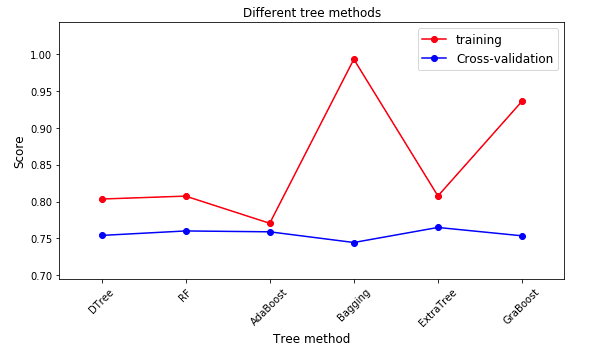

In [ ]:
#SVM
TOL = 1e-4 
MAX_ITER = 1000 
clf_svm = { 
    'SVM-rbf': SVC(kernel='rbf', 
                   max_iter=MAX_ITER, 
                   tol=TOL, 
                   random_state=RANDOM_STATE, decision_function_shape='ovr'), 
    'SVM-poly': SVC(kernel='poly', max_iter=MAX_ITER, 
                    tol=TOL, random_state=RANDOM_STATE, 
                    decision_function_shape='ovr'), 
    'SVM-linear': SVC(kernel='linear', max_iter=MAX_ITER, 
                      tol=TOL, random_state=RANDOM_STATE, 
                      decision_function_shape='ovr'), 
    'LinearSVC': LinearSVC(max_iter=MAX_ITER, tol=TOL, 
                           random_state=RANDOM_STATE, multi_class = 'ovr') 
train_score_svm = [] 
cv_score_svm = [] 
kf = KFold(n_splits=3, random_state=RANDOM_STATE) 
k_ndcg = 5 
for key in clf_svm.keys(): 
    clf = clf_svm.get(key) 
    train_score_iter = [] 
    cv_score_iter = [] 
    for train_index, test_index in kf.split(xtrain_new, ytrain_new): 
        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :] 
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index] 
        clf.fit(X_train, y_train) 
        y_pred = clf.decision_function(X_test) 
        train_ndcg_score = ndcg_score(y_train, clf.decision_function(X_train), k = k_ndcg) 
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg) 
        train_score_iter.append(train_ndcg_score) 
        cv_score_iter.append(cv_ndcg_score) 
    train_score_svm.append(np.mean(train_score_iter)) 
    cv_score_svm.append(np.mean(cv_score_iter)) }


In [ ]:
ymin = np.min(cv_score_svm)-0.05 
ymax = np.max(train_score_svm)+0.05 
x_ticks = clf_svm.keys() 
plt.figure(figsize=(8,5)) 
plt.plot(range(len(x_ticks)), train_score_svm, 'ro-', label = 'training') 
plt.plot(range(len(x_ticks)),cv_score_svm, 'bo-', label = 'Cross-validation') 
plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10) 
plt.xlabel("Tree method", fontsize = 12) 
plt.ylabel("Score", fontsize = 12) 
plt.xlim(-0.5, 3.5) 
plt.ylim(ymin, ymax) 
plt.legend(loc = 'best', fontsize = 12) 
plt.title("Different SVM methods") 
plt.tight_layout()


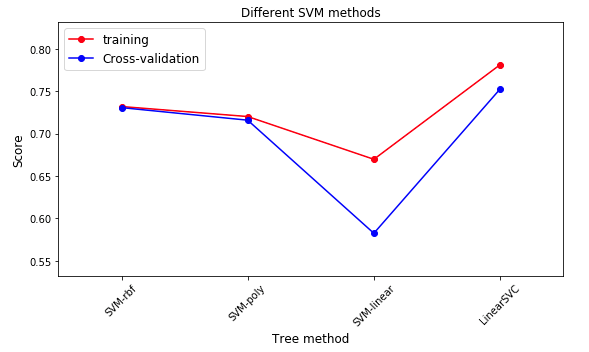

In [ ]:
#xgboost
import xgboost as xgb 
def customized_eval(preds, dtrain): 
    labels = dtrain.get_label() 
    top = [] 
    for i in range(preds.shape[0]): 
        top.append(np.argsort(preds[i])[::-1][:5]) 
        mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int) 
        score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1)) 
        return 'ndcg5', score 
    # xgboost parameters 
    NUM_XGB = 200 
    params = {} 
    params['colsample_bytree'] = 0.6 
    params['max_depth'] = 6 
    params['subsample'] = 0.8 
    params['eta'] = 0.3 
    params['seed'] = RANDOM_STATE 
    params['num_class'] = 12 
    params['objective'] = 'multi:softprob' # output the probability instead of class. 
    train_score_iter = [] 
    cv_score_iter = [] 
    kf = KFold(n_splits = 3, random_state=RANDOM_STATE) 
    k_ndcg = 5 
    for train_index, test_index in kf.split(xtrain_new, ytrain_new): 
        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :] 
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index] 
        train_xgb = xgb.DMatrix(X_train, label= y_train) 
        test_xgb = xgb.DMatrix(X_test, label = y_test) 
        watchlist = [ (train_xgb,'train'), (test_xgb, 'test') ] 
        bst = xgb.train(params, train_xgb, NUM_XGB, watchlist, feval = customized_eval, verbose_eval = 3, early_stopping_rounds = 5) 
        #bst = xgb.train( params, dtrain, num_round, evallist ) 
        y_pred = np.array(bst.predict(test_xgb)) 
        y_pred_train = np.array(bst.predict(train_xgb)) 
        train_ndcg_score = ndcg_score(y_train, y_pred_train , k = k_ndcg) 
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg) 
        train_score_iter.append(train_ndcg_score) 
        cv_score_iter.append(cv_ndcg_score) 
train_score_xgb = np.mean(train_score_iter) 
cv_score_xgb = np.mean(cv_score_iter) 
print ("\nThe training score is: {}".format(train_score_xgb)) 
print ("The cv score is: {}\n".format(cv_score_xgb))


In [ ]:
#模型比较
model_cvscore = np.hstack((cv_score_lr, cv_score_tree, cv_score_svm, cv_score_xgb)) 
model_name = np.array(['LinearReg','ExtraTree','DTree','RF','GraBoost','Bagging','AdaBoost','LinearSVC','SVM-linear','SVM-rbf','SVM-poly','Xgboost']) 
fig = plt.figure(figsize=(8,4)) 
sns.barplot(model_cvscore, model_name, palette="Blues_d") 
plt.xticks(rotation=0, size = 10) 
plt.xlabel("CV score", fontsize = 12) 
plt.ylabel("Model", fontsize = 12) 
plt.title("Cross-validation score for different models") 
plt.tight_layout()


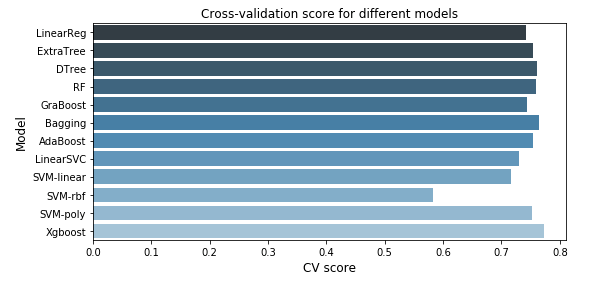